In [5]:
import pandas as pd 
import numpy as  np 
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

In [2]:
def load_data(file_path):
    return pd.read_csv(file_path)

In [3]:
data = pd.read_csv('/Users/julia/Downloads/merged_data_csv_1_exported_1.csv')

In [4]:
#Student_ID

def get_student_data(data, student_id):
    """Извлекает данные студента по его ID."""
    student_data = data[data['ID_'] == student_id]
    if student_data.empty:
        print(f"Student with ID {student_id} was not found in the database")
        return None
    return student_data


In [7]:
# Total/Unique Ratio

def calculate_ratios(data):
    """Вычисляет отношение общего количества слов к уникальным словам."""
    data['Total_Unique_Ratio'] = data['Total_words'] / data['Unique_words']
    return data.dropna(subset=['Total_words', 'Unique_words', 'Total_Unique_Ratio'])

In [8]:
#Cleaning and screen of missing values 

def scale_data(data):
    """Масштабирует указанные данные с помощью StandardScaler."""
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[['Total_words', 'Unique_words', 'Total_Unique_Ratio']]),
                               columns=['Total_words', 'Unique_words', 'Total_Unique_Ratio'])
    return scaled_data

In [10]:
def check_nan(scaled_data):
    """Проверяет наличие NaN значений в масштабированных данных."""
    nan_mask = np.isnan(scaled_data)
    if np.any(nan_mask):
        print("В данных есть NaN после масштабирования")
        nan_count = np.sum(nan_mask)
        print(f'Количество NaN: {nan_count}')
    else:
        print("NaN в данных нет после масштабирования")
    return scaled_data

In [11]:
def clean_data(data, scaled_data):
    """Очищает данные от NaN значений."""
    rows_to_keep = ~data[['Total_words', 'Unique_words', 'Total_Unique_Ratio']].isna().any(axis=1)
    return scaled_data[rows_to_keep.values], data[rows_to_keep]

In [12]:
#Clustering

def perform_kmeans(scaled_data, n_clusters=10):
    inertia = []
    for k in range(1, n_clusters +1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)
    return inertia


#Присваивает кластеры на основе оптимального числа кластеров
def assign_clusters(data, scaled_data, optimal_k):
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
    data['Cluster'] = kmeans_optimal.fit_predict(scaled_data)
    return data

#Метод локтя
def plot_elbow(inertia):
    """Строит график локтя для выбора оптимального числа кластеров."""
    plt.plot(range(1, len(inertia) + 1), inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')  # исправлено: заменена запятая на точку
    plt.show()

In [13]:
#Вычисляет сравнительные метрики студента и группы

def calculate_comparison(data, student_total_words, student_unique_words, student_total_unique_ratio):
    overall_stats = data[['Total_words', 'Unique_words', 'Total_Unique_Ratio']].describe()
    student_comparison = pd.DataFrame({
        'Indicator': ['Total Words', 'Unique Words', 'Total/Unique Ratio'],
        'Student Value': [student_total_words, student_unique_words, student_total_unique_ratio], 
        'Group Mean': [overall_stats.loc['mean', 'Total_words'],
                       overall_stats.loc['mean', 'Unique_words'],
                       overall_stats.loc['mean', 'Total_Unique_Ratio']]
    })
    return student_comparison

def plot_student_vs_group(student_id, student_comparison):
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    metrics = ['Total Words', 'Unique Words', 'Total/Unique Ratio']
    for i, metric in enumerate(metrics): 
        axs[i].bar(['Student', 'Average'], student_comparison.iloc[i, 1:], color=['blue', 'gray'])
        axs[i].set_title(metric)
    plt.suptitle(f"Student {student_id} vs. Group Performance Metrics")
    plt.show()

In [14]:
def plot_cluster_distribution(data, student_id):
    """Строит круговую диаграмму распределения студентов по кластерам."""
    cluster_counts = data['Cluster'].value_counts()
    student_cluster = data[data['ID_'] == student_id]['Cluster'].values[0]
    
  
    student_count_in_cluster = cluster_counts[student_cluster]

  
    sizes = [student_count_in_cluster, cluster_counts.sum() - student_count_in_cluster]
    labels = [f'Cluster {student_cluster} ({student_count_in_cluster})', 'Other Clusters']


    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgray'])
    plt.title(f'Distribution of Clusters for Student {student_id}')
    plt.axis('equal')  # Чтобы диаграмма была круговой

    # Текстовое сообщение под диаграммой
    plt.figtext(0.5, -0.1, 
                f'Student with ID {student_id} belongs to Cluster {student_cluster}, '
                f'which contains {student_count_in_cluster} students.',
                wrap=True, horizontalalignment='center', fontsize=12)

    plt.show()


NaN в данных нет после масштабирования


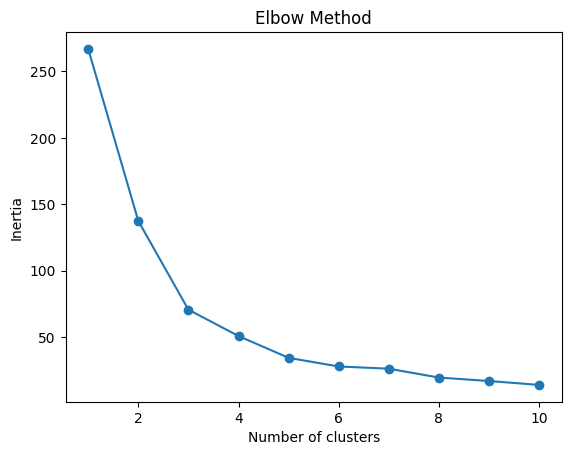

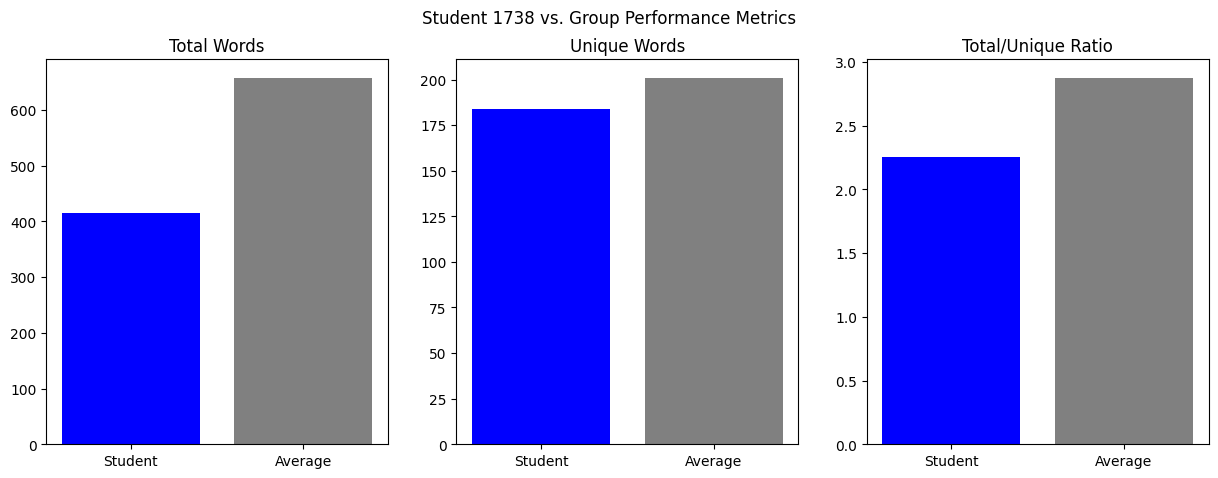

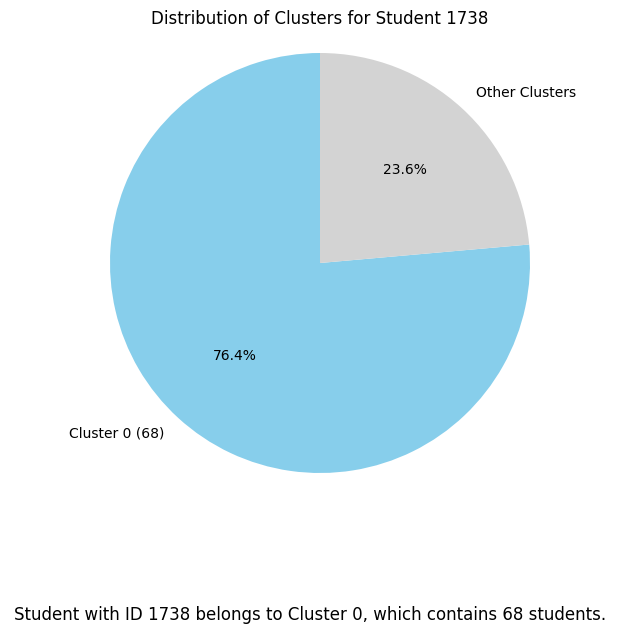

In [19]:
file_path = '/Users/julia/Downloads/merged_data_csv_1_exported_1.csv'
student_id = 1738


# Выполнение функций
data = load_data(file_path)
student_data = get_student_data(data, student_id)

if student_data is not None:
    student_total_words = student_data['Total_words'].values[0]
    student_unique_words = student_data['Unique_words'].values[0]
    student_total_unique_ratio = student_total_words / student_unique_words

    data = calculate_ratios(data)
    data_scaled = scale_data(data)
    data_scaled = check_nan(data_scaled)
    data_scaled_clean, data_clean = clean_data(data, data_scaled)

    inertia = perform_kmeans(data_scaled_clean)
    plot_elbow(inertia)

    # Запрос оптимального числа кластеров
    while True:
        try:
            optimal_k = int(input("Enter the optimal number of clusters based on the elbow plot: "))
            if optimal_k <= 0:
                raise ValueError("Number of clusters must be positive.")
            break
        except ValueError as e:
            print(e)

    data_with_clusters = assign_clusters(data_clean, data_scaled_clean, optimal_k)

    student_comparison = calculate_comparison(data_with_clusters, student_total_words, student_unique_words, student_total_unique_ratio)
    plot_student_vs_group(student_id, student_comparison)

    # Построение круговой диаграммы для кластеров
    plot_cluster_distribution(data_with_clusters, student_id)
else:
    print("Data processing terminated due to missing student data.")